## Creating Monthly Time Series Dataset and ARMA Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

In [2]:
events_df = pd.read_csv(
    "data/cleaned_dat_train1.csv",
    low_memory=True,
    parse_dates=['event_timestamp'],
    usecols=['ed_id', 'event_timestamp'],
    dtype={
        'ed_id': np.uint8
    }
)

In [5]:
events_df[events_df['ed_id'] == 28].shape

(279363, 2)

In [6]:
orders_shipped = events_df[events_df['ed_id'] == 28].reset_index(drop=True)

In [7]:
orders_shipped.head()

,ed_id,event_timestamp
0,28,2021-06-23 00:00:00+00:00
1,28,2021-04-08 00:00:00+00:00
2,28,2021-08-18 00:00:00+00:00
3,28,2021-04-05 00:00:00+00:00
4,28,2022-06-07 00:00:00+00:00


In [33]:
orders_shipped.to_csv("data/order_shipped_dates.csv", index=False)

In [4]:
# After creating dataset once, use this line to read in the data
orders_shipped = pd.read_csv("data/order_shipped_dates.csv", parse_dates=['event_timestamp'])

In [8]:
weekly_totals = (
    orders_shipped
        .set_index('event_timestamp')
        .resample('W')
        .size()
)

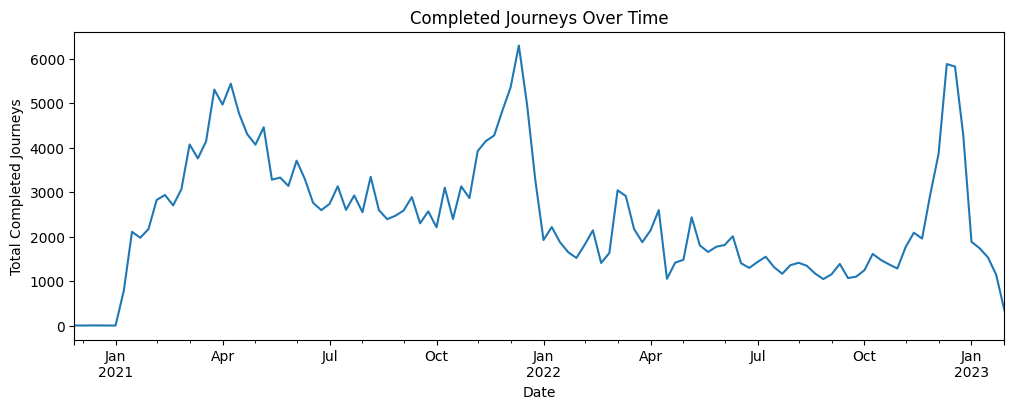

In [9]:
weekly_totals.head()

weekly_totals.plot(figsize=(12, 4))
plt.xlabel('Date')
plt.ylabel('Total Completed Journeys')
plt.title('Completed Journeys Over Time')
plt.show()

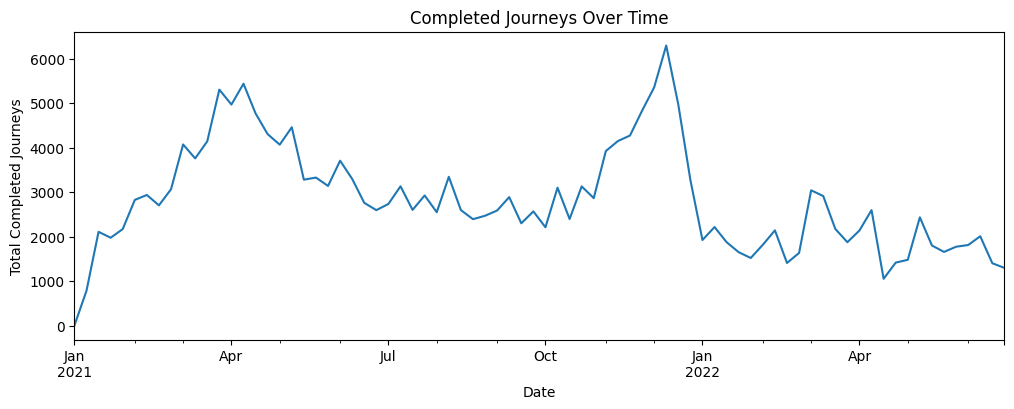

In [80]:
X_train_weekly = weekly_totals['2021-01-01':'2022-06-30']
X_test_weekly = weekly_totals['2022-07-01':]

X_train_weekly.plot(figsize=(12, 4))
plt.xlabel('Date')
plt.ylabel('Total Completed Journeys')
plt.title('Completed Journeys Over Time')
plt.show()

In [81]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X_train_weekly.values)
print(f"p-value from ADF Test: {result[1]}")

p-value from ADF Test: 0.4473948571153926


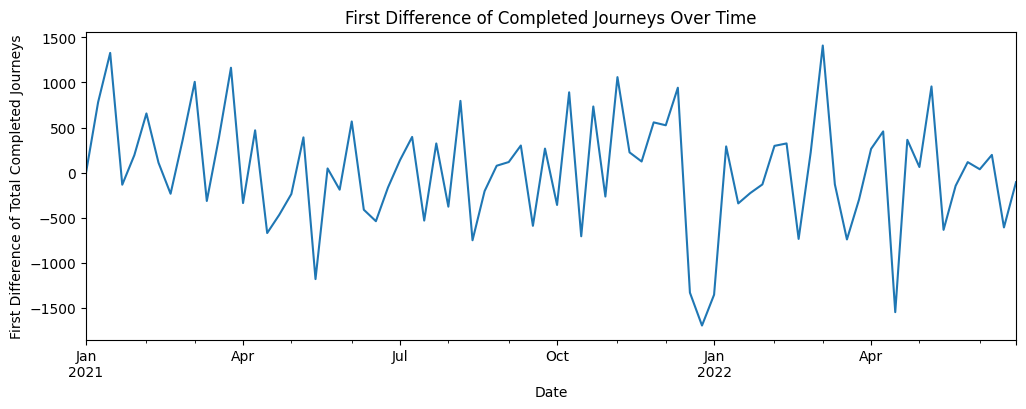

In [82]:
X_train_weekly_diff = weekly_totals['2021-01-01':'2022-06-30'].diff().fillna(0)

X_train_weekly_diff.plot(figsize=(12, 4))
plt.xlabel('Date')
plt.ylabel('First Difference of Total Completed Journeys')
plt.title('First Difference of Completed Journeys Over Time')
plt.show()

In [83]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X_train_weekly_diff.values)
print(f"p-value from ADF Test: {result[1]}")

p-value from ADF Test: 0.005617392190992785


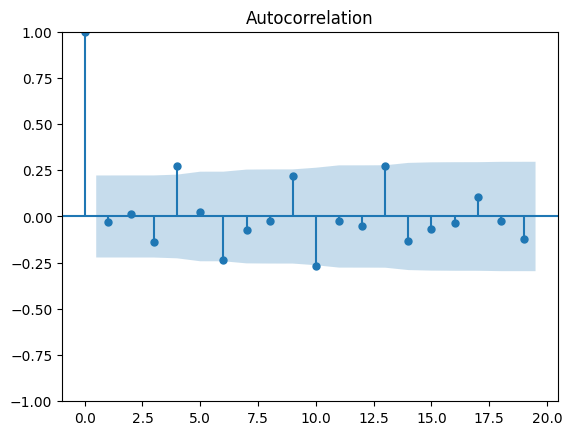

In [84]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(X_train_weekly_diff.values)
plt.show()

Significant lags at 4, (maybe) 6, 10, and 13 weeks for ACF Plot

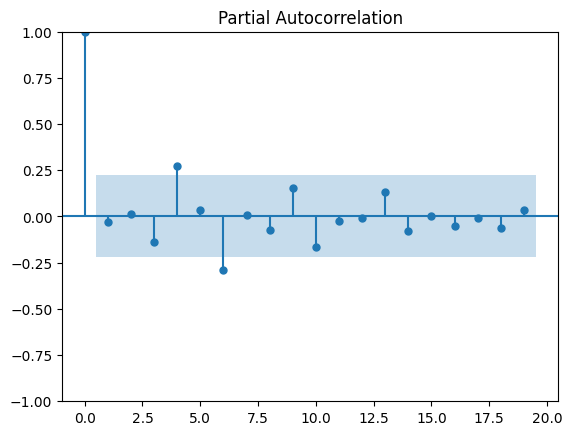

In [85]:
plot_pacf(X_train_weekly_diff.values)
plt.show()

Significant lags at 4 and 6 weeks for PACF plot.

In [106]:
# AR order of 6 and MA order of 13
# model = ARIMA(X_train_weekly, order=(4, 1, 4))
model = ARIMA(X_train_weekly, order=(6, 1, 13))
res = model.fit(method="innovations_mle")
# model = ARIMA(X_train_weekly, order=(6, 1, 4))
# res = model.fit(method="hannan_rissanen")
# res = model.fit()

C:\Users\david\AppData\Local\Temp\ipykernel_39712\643815167.py:4: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  res = model.fit(method="innovations_mle")


In [107]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   78
Model:                ARIMA(6, 1, 13)   Log Likelihood                -592.402
Date:                Wed, 28 Jan 2026   AIC                           1224.805
Time:                        07:24:51   BIC                           1271.681
Sample:                    01-03-2021   HQIC                          1243.555
                         - 06-26-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6668      6.270     -0.106      0.915     -12.956      11.623
ar.L2          0.1164      5.345      0.022      0.983     -10.359      10.592
ar.L3         -0.3178      0.787     -0.404      0.686      -1.861       1.225
ar.L4          0.4543      2.514      0.181      0.857      -4.473       5.382
ar.L5          0.6894      2.313      0.298      0.766      -3.843       5.222
ar.L6         -0.1088      4.528     -0.024      0.981      -8.984       8.766
ma.L1          0.7842      6.608      0.119      0.906     -12.167      13.735
ma.L2         -0.0853      6.355     -0.013      0.989     -12.541      12.370
ma.L3          0.2097      2.029      0.103      0.918      -3.767       4.186
ma.L4         -0.4047      2.837     -0.143      0.887      -5.964       5.155
ma.L5         -0.7264      2.193     -0.331      0.740      -5.024       3.571
ma.L6         -0.2731      4.765     -0.057      0.954      -9.612       9.066
ma.L7         -0.1761      2.442     -0.072      0.943      -4.963       4.611
ma.L8         -0.1499      1.600     -0.094      0.925      -3.285       2.985
ma.L9         -0.1414      1.418     -0.100      0.921      -2.920       2.637
ma.L10        -0.0782      1.338     -0.058      0.953      -2.700       2.543
ma.L11        -0.0827      0.946     -0.087      0.930      -1.937       1.772
ma.L12         0.0856      0.903      0.095      0.925      -1.684       1.856
ma.L13         0.0484      0.349      0.139      0.890      -0.636       0.733
sigma2      2.585e+05      0.000    2.2e+09      0.000    2.59e+05    2.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.24
Prob(Q):                              0.92   Prob(JB):                         0.03
Heteroskedasticity (H):               0.53   Skew:                            -0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.18e+26. Standard errors may be unstable.
"""

In [108]:
forecast = res.get_forecast(steps=31)
y_hat = forecast.predicted_mean

In [109]:
y_hat.tail()

2023-01-01 00:00:00+00:00    2355.140237
2023-01-08 00:00:00+00:00    2595.939802
2023-01-15 00:00:00+00:00    2326.784381
2023-01-22 00:00:00+00:00    2442.726466
2023-01-29 00:00:00+00:00    2333.825952
Freq: W-SUN, Name: predicted_mean, dtype: float64

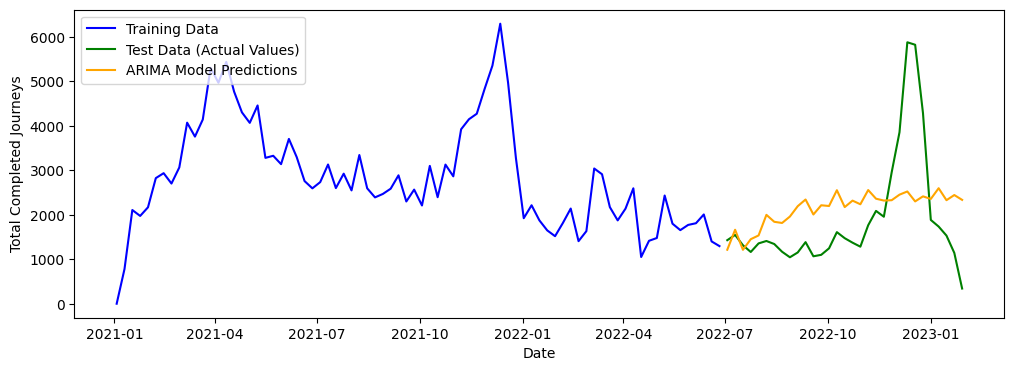

In [110]:
plt.figure(figsize=(12, 4))
plt.plot(X_train_weekly.index, X_train_weekly, c='blue', label='Training Data')
plt.plot(X_test_weekly.index, X_test_weekly, c='green', label='Test Data (Actual Values)')
plt.plot(y_hat.index, y_hat, c='orange', label='ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Total Completed Journeys')
plt.legend(loc='upper left')
plt.show()

In [ ]:
monthly_totals = (
    orders_shipped
        .set_index('event_timestamp')
        .resample('MS')
        .size()
)

Let's first subset the data to a realistic date range, excluding the first few months because it is unrealistic for us to have a lot of completed journeys during this times (since it takes some time for journeys to complete and we only include journeys that started after November 3, 2020). We will also exclude the last month (January 2023) because we don't have a full month's worth of data.

In [ ]:
monthly_totals = monthly_totals['2021-01-01':'2022-12-31']

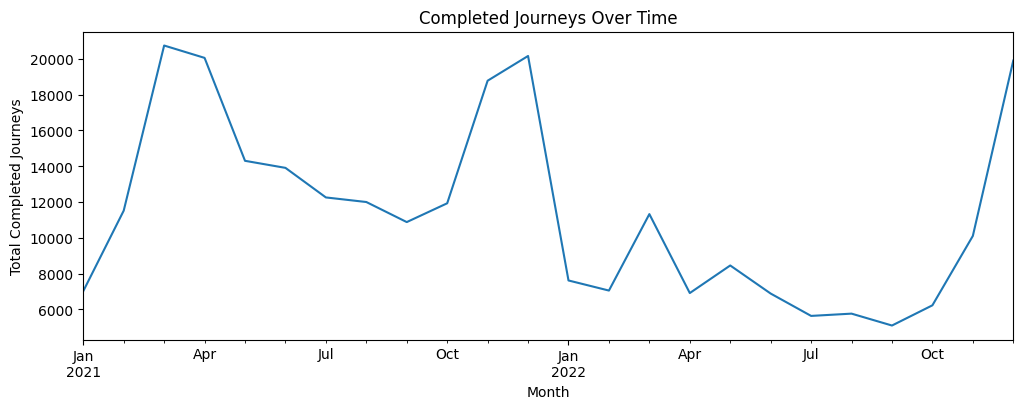

In [67]:
monthly_totals.plot(figsize=(12, 4))
plt.xlabel('Month')
plt.ylabel('Total Completed Journeys')
plt.title('Completed Journeys Over Time')
plt.show()

* ACF (Autocorrelation function): The Pearson correlation by lining up the time series values (the total number of orders shipped) by offsetting one of the lists by k months (where k is the lag). For example, if we wanted the lag-2 autocorrelation, we would align Jan-Mar, Feb-Apr, Mar-May, etc. treating the older month as x and the more recent month as y. This can be decomposed into two components

    * Component 1: The direct effect from lag-k to the current month (In our example, the direct effect of the number of orders shipped two months ago on the current month's total).
    * Component 2: The indirect effect from lag-k through all lags in between lag-k and the previous month (In our example, the effect of orders shipped two months ago on the number of orders shipped last month and then the effect from last month on the current month).

* PACF (Partial Autocorrelation function) only cares about the **direct** effect from k months ago on the current month (just Component 1 from above). To find the PACF at lag k, we fit a regression model $S_t = \phi_{k1}S_{t-1} + \phi_{k2}S_{t-2} + ... + \phi_{kk}S_{t-k} + \epsilon_t$, where each $\phi_{ki}$ gives the direct effect of the i-th lag on the current month.


If PACF is high, then there is a strong **direct** effect of lag k on the current month. ACF analyzes the total impacts through all intermediate lags.

Interpreting PACF Plot: Anything outside the error bands is a significant lag; anything within the error bands is not statistically significant and is no different than 0. This can help us determine the order of the AR component of our ARMA model.

Interpreting ACF Plot: Similar to the PACF Plot, we look for significant lags that are outside the error bands to help us determine the order of the MA component of our model.

Before this though, we must check for stationarity using the Augmented Dickey Fuller (ADF) test. Stationarity is a key assumption of ARIMA-based models. We want the p-value of this test to be less than 0.05.

Let's reserve the last 6 months (July-December 2022) as test data and the rest of our dataset as training data (January 2021-June 2022).

In [82]:
X_train = monthly_totals[:'2022-06-30']
X_test = monthly_totals['2022-07-01':]

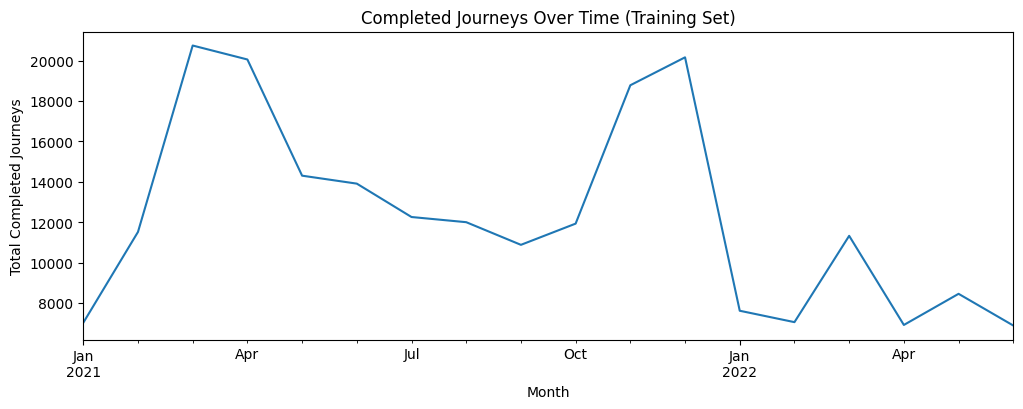

In [86]:
X_train.plot(figsize=(12, 4))
plt.xlabel('Month')
plt.ylabel('Total Completed Journeys')
plt.title('Completed Journeys Over Time (Training Set)')
plt.show()

In [84]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X_train.values)
print(f"p-value from ADF Test: {result[1]}")

p-value from ADF Test: 1.0


The p-value here is essentially 1. With a significance level of $\alpha=0.05$, we fail to reject the null hypothesis. Our data is most definitely NOT stationary.
We can see this in two big ways:

1. We do not have constant mean (the average number of completed journeys per month is much higher before 2022 than during 2022).
2. We do not have constant variance (there are periods of high and low volatility).

We can resolve this by taking differences of our data until it becomes stationary.

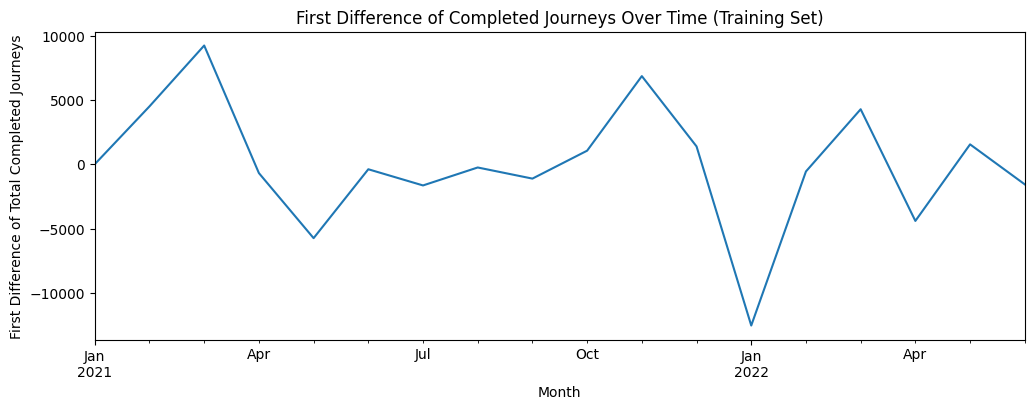

In [87]:
first_diff = X_train.diff().fillna(0)

first_diff.plot(figsize=(12, 4))
plt.xlabel('Month')
plt.ylabel('First Difference of Total Completed Journeys')
plt.title('First Difference of Completed Journeys Over Time (Training Set)')
plt.show()

This already looks a lot better. It seems like our mean is generally constant over time although we may still not have a non-constant variance.

In [88]:
result = adfuller(first_diff.values)
print(f"p-value from ADF Test: {result[1]}")

p-value from ADF Test: 0.87009499536474


As we can see, we still fail to reject the null hypothesis at a significance level of $\alpha=0.05$, so our data is still not stationary.

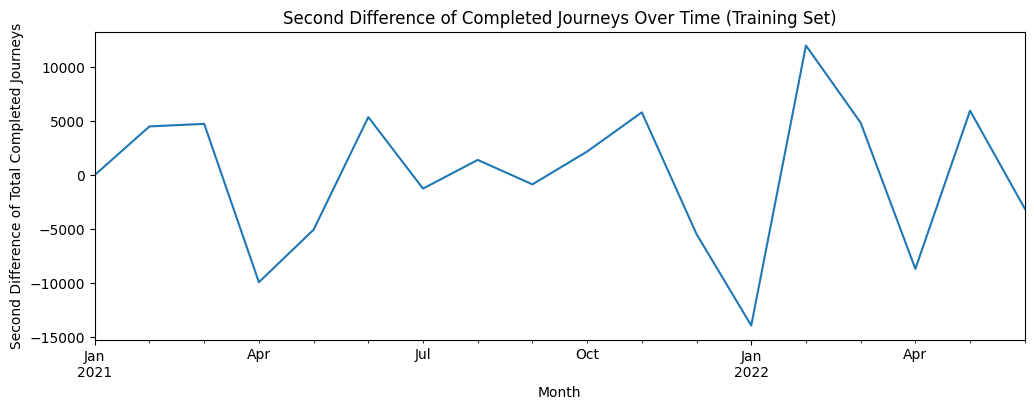

In [89]:
second_diff = first_diff.diff().fillna(0)

second_diff.plot(figsize=(12, 4))
plt.xlabel('Month')
plt.ylabel('Second Difference of Total Completed Journeys')
plt.title('Second Difference of Completed Journeys Over Time (Training Set)')
plt.show()

We are certainly a lot closer to getting stationary data. The mean appears to be constant, but the variance is still greater near the end of our training period than at the beginning.

In [90]:
result = adfuller(second_diff.values)
print(f"p-value from ADF Test: {result[1]}")

p-value from ADF Test: 0.09650387999856447


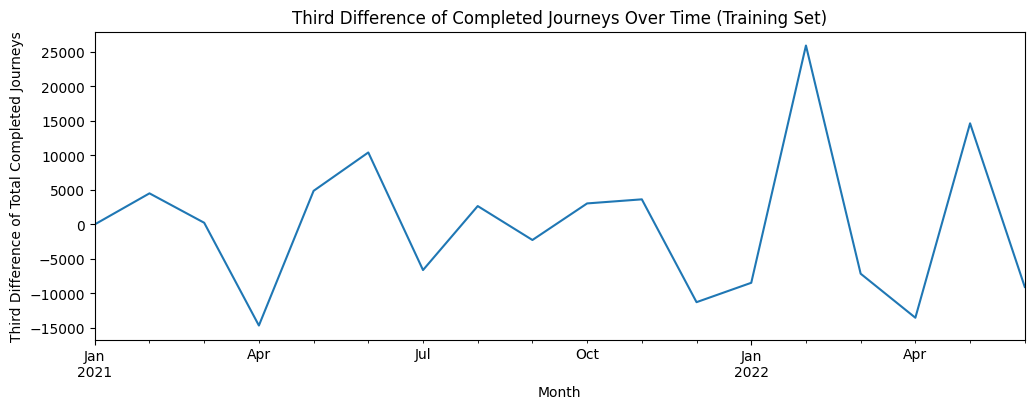

In [91]:
third_diff = second_diff.diff().fillna(0)

third_diff.plot(figsize=(12, 4))
plt.xlabel('Month')
plt.ylabel('Third Difference of Total Completed Journeys')
plt.title('Third Difference of Completed Journeys Over Time (Training Set)')
plt.show()

In [92]:
result = adfuller(third_diff.values)
print(f"p-value from ADF Test: {result[1]}")

p-value from ADF Test: 0.0


We finally have stationary data that we can work with!

Now let's look at the ACF and PACF Plots.

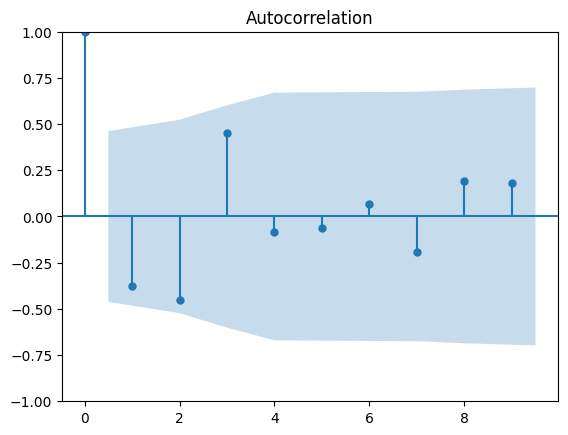

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(third_diff.values)
plt.show()

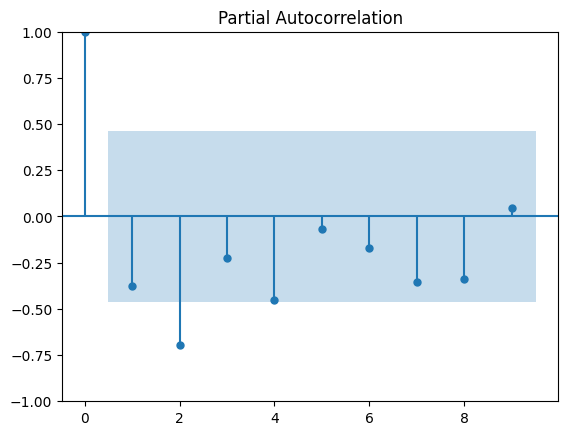

In [94]:
plot_pacf(third_diff.values)
plt.show()

There don't seem to be any significant lags in the ACF plot, but we definitely have a significant lag of 2 in the PACF plot and possibly another significant lag of 4.

Based on this, we may be interested in fitting an AR model with order 2 or 4 on the differenced data.

In [ ]:
# from statsmodels.tsa.ar_model import AutoReg

# ar_model = AutoReg(third_diff, lags=2).fit()

In [ ]:
# ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   18
Model:                     AutoReg(2)   Log Likelihood                -163.762
Method:               Conditional MLE   S.D. of innovations           6742.461
Date:                Tue, 27 Jan 2026   AIC                            335.524
Time:                        17:35:39   BIC                            338.614
Sample:                    03-01-2021   HQIC                           335.682
                         - 06-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -658.2668   1688.452     -0.390      0.697   -3967.573    2651.039
y.L1          -0.6394      0.171     -3.743      0.000      -0.974      -0.305
y.L2          -0.7754      0.182     -4.250      0.000      -1.133      -0.418
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4123           -1.0582j            1.1356           -0.3091
AR.2           -0.4123           +1.0582j            1.1356            0.3091
-----------------------------------------------------------------------------
"""

In [150]:
# AR order of 2, 3rd difference of original data, and MA order of 0
model = ARIMA(X_train, order=(4, 3, 0))
res = model.fit()

In [151]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   18
Model:                 ARIMA(4, 3, 0)   Log Likelihood                -151.801
Date:                Tue, 27 Jan 2026   AIC                            313.602
Time:                        17:50:05   BIC                            317.142
Sample:                    01-01-2021   HQIC                           313.564
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9644      0.210     -4.600      0.000      -1.375      -0.553
ar.L2         -1.3793      0.269     -5.119      0.000      -1.907      -0.851
ar.L3         -0.7621      0.283     -2.697      0.007      -1.316      -0.208
ar.L4         -0.7384      0.198     -3.734      0.000      -1.126      -0.351
sigma2      2.988e+07   3.42e-09   8.74e+15      0.000    2.99e+07    2.99e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.99   Prob(JB):                         0.41
Heteroskedasticity (H):               0.47   Skew:                            -0.84
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.89e+31. Standard errors may be unstable.
"""

In [152]:
forecast = res.get_forecast(steps=6)
y_hat = forecast.predicted_mean

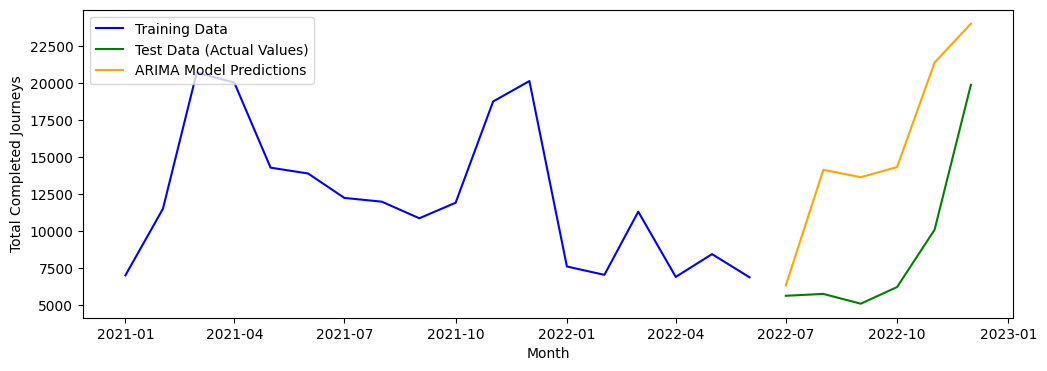

In [153]:
plt.figure(figsize=(12, 4))
plt.plot(X_train.index, X_train, c='blue', label='Training Data')
plt.plot(X_test.index, X_test, c='green', label='Test Data (Actual Values)')
plt.plot(y_hat.index, y_hat, c='orange', label='ARIMA Model Predictions')
plt.xlabel('Month')
plt.ylabel('Total Completed Journeys')
plt.legend(loc='upper left')
plt.show()